In [50]:
import torch
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt

# Know your Data

In [191]:
# Design custom dataset 
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __getitem__(self, index):
        img1_path = self.data_list[index][0]
        img2_path = self.data_list[index][1]
        label_path = self.data_list[index][2]
        
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        label = Image.open(label_path).convert('L') # Load label as grayscale
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            label = self.transform(label)

        return img1, img2, label

    def __len__(self):
        return len(self.data_list)

data_list = []
for i in range(7):
    data_path = f'SZTAKI_AirChange_Benchmark/Szada/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

for i in range(5):
    data_path = f'SZTAKI_AirChange_Benchmark/Tiszadob/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

# Convert PIL image to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

siamese_dataset = SiameseDataset(data_list, transform=transform)
siamese_dataloader = torch.utils.data.DataLoader(siamese_dataset, batch_size=64, shuffle=False)

The shape of images is torch.Size([3, 640, 952])
The number of images in one batch = 12


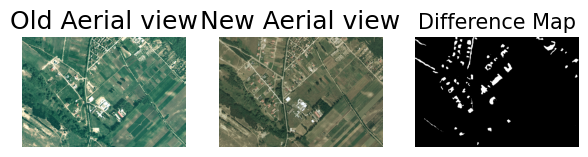

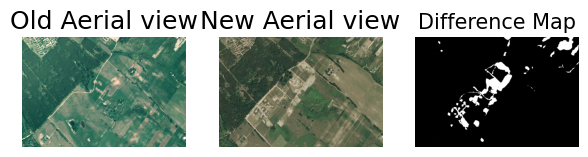

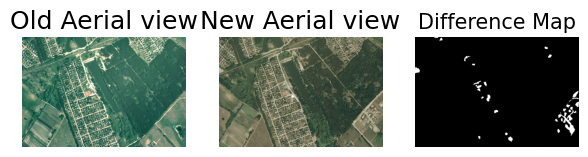

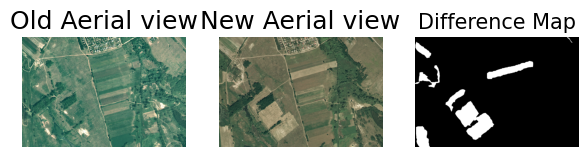

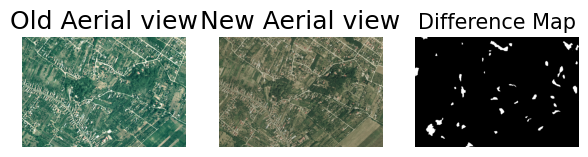

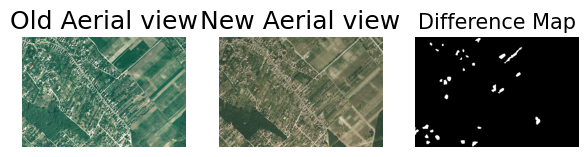

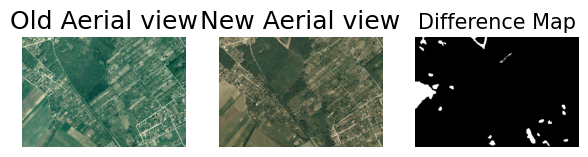

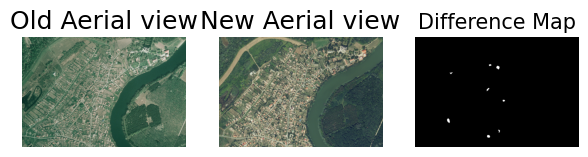

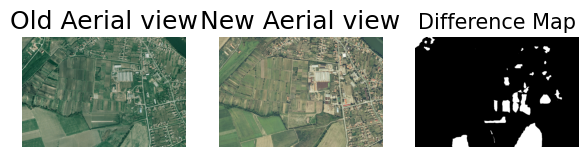

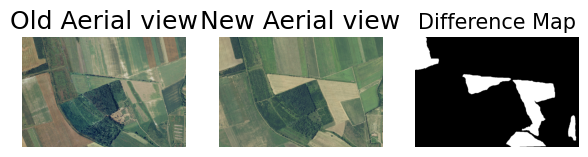

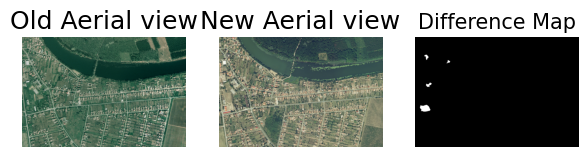

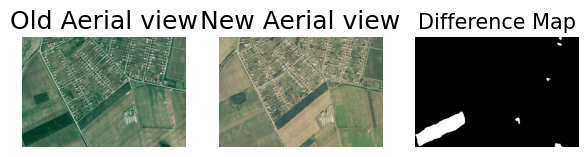

In [196]:
# Loop runs for iterations = number of batches. 
# We have only one batch for this dataset with batch_size = min(total number of images, 64)
for img1, img2, labels in siamese_dataloader:
    
    print(f'The shape of images is {img1.shape[1:]}')
    print(f'The number of images in one batch = {img1.shape[0]}')
    
    # You can vary the number_of_images value to print the set of number of images you need
    number_of_images = 12 # maximum size of img1.shape[0]
    
    for i, j in zip([x for x in range(number_of_images)], [(max(3, number_of_images) * x + 1) for x in range(number_of_images)]):
        
        # Process old image
        # Transpose is applied to all images to get the image in the form HWC from CHW
        image1 = img1[i].transpose(0, 2).transpose(0, 1)

        plt.figure(figsize = (30, 30))
        plt.subplot(number_of_images, max(3, number_of_images), j)
        plt.imshow(image1)
        plt.axis('off')
        plt.title('Old Aerial view', fontsize = '18')

        # Process new image
        image2 = img2[i].transpose(0, 2).transpose(0, 1)   

        plt.subplot(number_of_images, max(3, number_of_images), j + 1)
        plt.imshow(image2)
        plt.axis('off')
        plt.title('New Aerial view', fontsize = '18')

        # Process difference map label
        label = labels[i].transpose(0, 2).transpose(0, 1)

        plt.subplot(number_of_images, max(3, number_of_images), j + 2)
        plt.imshow(label, cmap = 'gray')
        plt.axis('off')
        plt.title('Difference Map', fontsize = '15')
            